# Response to article

**Predict**: Upvotes, downvotes, number of comments, length of comments, ...

**Plus**: Interpretable model

See [summary](#summary) at the end.

In [1]:
%matplotlib inline
import re
from time import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_09.csv')#.sample(1000)
df_com = pd.read_csv('comments_2017_09.csv')#.sample(100000) # crop because battery life
# Make float better readable
pd.options.display.float_format = '{:.3f}'.format

In [2]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return ((time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return (time).hour

def get_weekday(time):
    return (time).weekday()

df_com['time_dt'] = df_com['time'].apply(get_dt_obj)
df_com['time_since_epoch'] = df_com['time_dt'].apply(time_since_epoch)
df_com['hour'] = df_com['time_dt'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time_dt'].apply(get_weekday) # 0 = Monday
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['con_num_words'] = df_com['con'].apply(lambda x: len(x.split()))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['activity'] = df_com['vup'] + df_com['vdo']

df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)
df_art['cat_copy'] = df_art['cat']
df_art = pd.get_dummies(df_art, columns=['cat'])

df_art['header_len'] = df_art['header'].apply(lambda x: len(x))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))
df_art['text_num_words'] = df_art['text'].apply(lambda x: len(str(x).split()))
df_art['text_n_periods'] = df_art['text'].apply(lambda x: len(str(x).split('.')))

# Left inner join
# Take care to not give too much information from the comments into df_merge
df_merge = pd.merge(left=df_com[['tId', 'time_since_epoch', 'weekday', 'hour', 'score', 'activity']], right=df_art, left_on='tId', right_on='tId')

# Remove rows with missing values
# use .count() to check for missing values
df_merge.dropna(axis=0, how='any', inplace=True)

# Get order of comments per article
df_merge = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')

# Get article specific statistics, group = article
def get_art_statistics(group):
    first = group.iloc[:1]['time_since_epoch']
    group['art_first_weekday'] = group.iloc[:1]['weekday']
    group['art_first_hour'] = group.iloc[:1]['hour']

    #group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)

    # Attention: this columns give (unreal) information to the estimator! 
    #group['art_score_sum'] = group['score'].sum()
    #group['art_activity_sum'] = group['activity'].sum()
    
    return group

df_merge = df_merge.apply(get_art_statistics)
df_merge = df_merge.groupby('tId').mean().reset_index()
df_merge = df_merge.merge(df_art[['tId', 'header', 'sub', 'text']], on='tId')
df_merge.head(2)[['num_comments', 'header']]


,num_comments,header
0,21.000,Was steckt hinter der Black-Death-Gruppe?
1,73.000,Tunesier lesen Aeschi nach Töff-Panne auf


In [3]:
df = pd.get_dummies(df_merge, columns=['art_first_weekday'], prefix='art_wd_')
df = pd.get_dummies(df, columns=['art_first_hour'], prefix='art_hr_')

df = df.drop(['cat_playview', 'cat_play'], axis=1)

# Memory optimization
# Technical stuff, contributes nothing to analysis
conv = df.select_dtypes(include=['int', 'float']).apply(pd.to_numeric,downcast='unsigned')
df[conv.columns] = conv
    
# Get pearson co-efficients
df.corr()


,tId,time_since_epoch,weekday,hour,score,activity,article_id,updated,num_comments,cat_ausland,...,art_hr__14.0,art_hr__15.0,art_hr__16.0,art_hr__17.0,art_hr__18.0,art_hr__19.0,art_hr__20.0,art_hr__21.0,art_hr__22.0,art_hr__23.0
tId,1.000,-0.030,0.004,-0.008,-0.001,-0.013,0.996,0.014,-0.021,-0.009,...,-0.011,0.010,0.000,-0.001,-0.036,0.025,-0.006,0.001,0.033,0.034
time_since_epoch,-0.030,1.000,0.011,0.027,0.030,0.045,-0.029,0.111,0.046,0.042,...,-0.027,0.007,0.035,0.007,0.017,-0.006,-0.015,0.011,0.028,-0.026
weekday,0.004,0.011,1.000,0.064,0.004,0.037,0.008,-0.056,0.030,0.006,...,-0.018,0.007,-0.006,0.013,0.028,0.038,0.035,0.031,0.025,0.037
hour,-0.008,0.027,0.064,1.000,0.062,0.082,-0.006,0.014,-0.037,-0.018,...,0.152,0.197,0.223,0.246,0.226,0.170,0.090,0.014,-0.096,-0.162
score,-0.001,0.030,0.004,0.062,1.000,0.797,-0.001,-0.045,0.002,0.049,...,0.003,0.001,-0.011,0.009,0.007,0.049,0.025,0.027,0.006,-0.012
activity,-0.013,0.045,0.037,0.082,0.797,1.000,-0.015,-0.049,0.015,0.106,...,0.005,0.000,-0.000,0.010,0.003,0.050,0.060,0.018,0.004,-0.013
article_id,0.996,-0.029,0.008,-0.006,-0.001,-0.015,1.000,0.015,-0.020,-0.010,...,-0.011,0.011,-0.002,-0.000,-0.035,0.024,-0.005,0.001,0.034,0.035
updated,0.014,0.111,-0.056,0.014,-0.045,-0.049,0.015,1.000,-0.003,-0.013,...,0.007,-0.013,0.015,0.023,0.033,-0.042,0.004,-0.003,-0.012,-0.005
num_comments,-0.021,0.046,0.030,-0.037,0.002,0.015,-0.020,-0.003,1.000,-0.010,...,0.009,-0.061,-0.036,-0.008,-0.043,-0.010,-0.015,-0.018,0.037,-0.041
cat_ausland,-0.009,0.042,0.006,-0.018,0.049,0.106,-0.010,-0.013,-0.010,1.000,...,-0.023,-0.003,-0.002,-0.018,-0.030,0.003,-0.007,-0.003,0.046,-0.021


total data:  2897



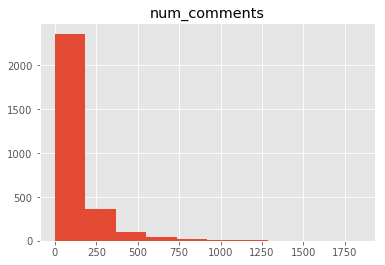

In [38]:
# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für, "
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns, "
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier, im,"
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

# Trying to remove outliers with nearly no text 
df = df[df['text_len']>100]

# Remove comment related stuff
df2 = df.drop(['score', 'activity', 'num_comments', #'vup', 'vdo', 
               # remove random stuff
               'tId', 'article_id',
               # not sure why those correlate so high with num_of_comments, but score does not decrease when removed
               'time_since_epoch', 'updated',
               # we one-hot-encoded these
               'hour', 'weekday',
              ], axis=1)
X = df2
y = df['num_comments'].values
#y = df['con_len']
#y = df['vup']

from sklearn.model_selection import train_test_split, learning_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("total data: ", len(X))

def plot_learning_curve(estimator, X, y, cv=None, ylim=None, n_jobs=1, train_sizes=np.linspace(.3, 1.0, 3)):
    plt.figure()
    plt.title('Learning curve')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples'); plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

df.hist(['num_comments'])
print()

#list(df2.columns)


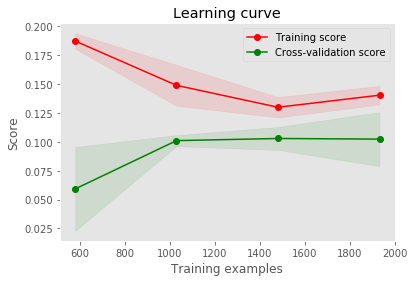

R^2: 0.11
Explained var: 0.11
Mean absolute err: 91.81
Mean squared err: 22491.87


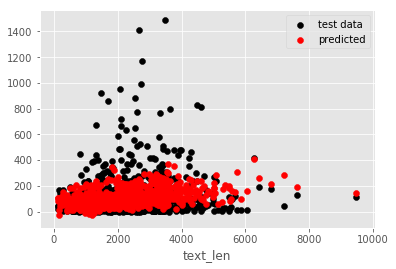

Done in 5.20 min.


0

In [46]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

class ItemSelector(BaseEstimator, TransformerMixin):
    '''
    Select a subset of data at a provided key.
    key: hashable, required
        The key corresponding to the desired value in a mappable.
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]
    
ngram_range = (1, 1)
st = time()
def no_numbers(x):
    return re.sub(r'(\d[\d\.])+', '', x.lower())
columns_nontext = [i for i in df2.columns if i not in ['header', 'sub', 'text']]
model = Pipeline([
    ('union', FeatureUnion(
        [
            ('statistics', Pipeline([
                ('selector', ItemSelector(key=columns_nontext)),
                #('poly', PolynomialFeatures(degree=2)), # reduces variance, reduces r2 a little bit
                ('scaler', StandardScaler()),
              #  ('reduce_dim', PCA(n_components=30)),
            ])),

            # article text information
            ('header', Pipeline([
                ('selector', ItemSelector(key='header')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range, stop_words=stop_words)),
                ('scaler', StandardScaler(with_mean=False)),
            ])),
            
            ('subheader', Pipeline([
                ('selector', ItemSelector(key='sub')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range, stop_words=stop_words)),
                ('scaler', StandardScaler(with_mean=False)),
            ])),
            
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('tfidf', TfidfVectorizer(min_df=0.2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range, stop_words=stop_words)),
                ('scaler', StandardScaler(with_mean=False)),
            ])),
        ], n_jobs=-1
    )),
    #('scaler', StandardScaler(with_mean=False)),
    # mutual_info_regression works better than f_regression, but gives no scores
    ('reduce_dim', SelectKBest(mutual_info_regression, k=35)), 
    ('model', LinearRegression(n_jobs=-1, fit_intercept=True, normalize=False))
])

# Just choose what you want to do
if True:
    plot_learning_curve(model, X, y, cv=3, n_jobs=-1,
                       train_sizes=np.linspace(.3, 1.0, 4))
    plt.show()

if True:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R^2: %1.2f" % r2_score(y_test, y_pred))
    print("Explained var: {:.2f}".format(explained_variance_score(y_test, y_pred)))
    print("Mean absolute err: {:.2f}".format(mean_absolute_error(y_test, y_pred)))
    print("Mean squared err: {:.2f}".format(mean_squared_error(y_test, y_pred)))
    # Residual plot
    X_res = X_test['text_len']
    plt.scatter(X_res, y_test, color='black', label='test data')
    plt.scatter(X_res, y_pred, color='red', label='predicted')
    plt.xlabel('text_len')
    plt.legend(); plt.show()

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        #'reduce_dim__score_func': [f_regression, mutual_info_regression],
        'reduce_dim__k': [30, 35, 40],
        # attention with these:
        #'model__fit_intercept': [True, False],
        #'model__normalize': [True, False]
                 }
    grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print(grid.best_params_)
    
print('Done in {:.2f} min.'.format((time() - st)/60))
# Make yourself noticeable to human
import os; os.system('say "this is dave. the computations are finished."')

In [47]:
# Which features are how important?
# TODO change when using with PolynomialFeatures

# Make a dict with feature=kscore from f_regression
features = {}
i=0
for col in columns_nontext:
    features[col] = model.named_steps['reduce_dim'].scores_[i]
    i+=1     
for word in model.named_steps['union'].transformer_list[1][1].named_steps['tfidf'].vocabulary_.keys():
    features['"'+word+'"'] = model.named_steps['reduce_dim'].scores_[i]
    i+=1
for word in model.named_steps['union'].transformer_list[2][1].named_steps['tfidf'].vocabulary_.keys():
    features['"'+word+'"'] = model.named_steps['reduce_dim'].scores_[i]
    i+=1
for word in model.named_steps['union'].transformer_list[3][1].named_steps['tfidf'].vocabulary_.keys():
    features['"'+word+'"'] = model.named_steps['reduce_dim'].scores_[i]
    i+=1
#print(len(model.named_steps['union'].transformer_list[1][1].named_steps['tfidf'].vocabulary_.keys()) )

# Print the best ones
import operator
features_sorted = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
for f, v in features_sorted[:50]:
    print("{}: {:.5f}".format(f, v))

text_len: 0.07837
text_n_periods: 0.06540
cat_finance: 0.02678
text_num_words: 0.02390
cat_people: 0.01355
header_len: 0.01343
cat_entertainment: 0.01184
art_hr__5.0: 0.01007
art_hr__16.0: 0.00883
cat_auto: 0.00821
art_hr__9.0: 0.00791
art_wd__3.0: 0.00750
art_wd__2.0: 0.00747
cat_digital: 0.00726
cat_fitness: 0.00707
art_wd__0.0: 0.00635
cat_sport: 0.00593
"wurden": 0.00581
cat_ausland: 0.00564
art_hr__21.0: 0.00525
art_hr__12.0: 0.00525
art_hr__7.0: 0.00378
"ab": 0.00342
"stoppt": 0.00285
"beim": 0.00262
"gibt": 0.00189
"gut": 0.00186
"herr": 0.00185
"waren": 0.00185
"karma": 0.00157
"viele": 0.00150
"günstige": 0.00146
"etwa": 0.00138
"hb": 0.00132
cat_wissen: 0.00117
"edle": 0.00112
"jahr": 0.00111
art_hr__13.0: 0.00107
"vermiest": 0.00088
"ketchup": 0.00078
"rund": 0.00073
"journalistin": 0.00068
"verleih": 0.00062
art_hr__8.0: 0.00052
"ring": 0.00052
"unglaublich": 0.00037
"emoji": 0.00034
"jungfreisinnige": 0.00023
art_hr__11.0: 0.00020
"gladbach": 0.00014


<a id="summary"></a>

### Summary

The articles with the most comments also get the highest "art_activity_sum", "is_answer", "con_len" and "con_num_words". This probably means that people are engaging into discussions and then write a lot of comments. Removing those columns from the training data makes the score of the model quite worse. 

The results don't make sense to me... strange features seem to be important.  
  
#### Number of comments
The features above seem to provoke comments. Please note that most comments seem to happen in the categories "finance" and "schweiz" and that the text length also has an influence.  
Some articles seem to have gotten a lot of comments.

#### Length of comments
Most important feature is text length. Then if people are answering from mobile, category "people", "schweiz" and "sport", also the length of the header plays a role.

#### Highest median upvotes
Score is too bad.

#### In general
More data or complexer model needed...